# Lecture 3: Classification and Logistic Regression

## Classification

### Binary Classification

We use the [breast cancer dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) from the UCI Machine Learning Repository to illustrate binary classification. The dataset contains 569 observations of breast cancer tumors, each with 30 features. The response variable is a binary variable indicating whether the tumor is malignant or benign. We will use logistic regression to predict the response variable.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer, make_regression

X, y = load_breast_cancer(return_X_y=True, as_frame=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [2]:
y.value_counts()

1    357
0    212
Name: target, dtype: int64

We often call label 1 the positive class and label 0 the negative class. In this case, the positive class is malignant and the negative class is benign.

## Review

### Linear Regression

In the last lecture, we introduced the linear regression model. We saw that the model is a linear function of the input features, and that the parameters of the model are learned by minimizing the mean squared error (MSE) between the model's predictions and the true labels. Given a set of $N$ training samples $\{(\mathbf{x}_i, y_i)\}_{i=1}^N$, a linear regression model $f_\mathbf{w}$ is defined as follows:
$$ f_\mathbf{w}(\mathbf{x}) = w_0 + w_1 x_{1} + w_2 x_{2} + \ldots + w_M x_{M} $$
If we let $x_0=1$, then we can rewrite the model as follows:
$$ f_\mathbf{w}(\mathbf{x}) = \mathbf{w}^\top \mathbf{x} $$
where $M$ is the dimensionality of $\mathbf{x}$ (the number of features). 

Let $\hat{y}_i=f_\mathbf{w}(\mathbf{x}_i)$ be the model's prediction of a sample $\mathbf{x}_i$, the MSE loss function is defined as follows:
$$ \mathcal{L}(\mathbf{w}) = \frac{1}{N} \sum_{i=1}^N \left(\hat{y}_i - y_i \right)^2 $$
The optimization of the model parameter $f_\mathbf{w}$ is performed by minimizing the MSE loss function, which is called the **ordinary least squares (OLS)** method. We can use the following formula to find the optimal parameters $\mathbf{w}^*$:
$$ \begin{aligned}
\mathbf{w}^* & = \left(\mathbf{X}^\top \mathbf{X}\right)^{-1} \mathbf{X}^\top \mathbf{y} \\
\end{aligned} $$
where $\mathbf{X}$ is the matrix of training samples (its $i$-th row is $\mathbf{x}_i$), and $\mathbf{y}$ is the vector of true labels. Note that this formula is only applicable when the matrix $\mathbf{X}^\top \mathbf{X}$ is invertible, which is only true when the number of training samples $N$ is greater than the number of features $M$.

array(62.88984391)

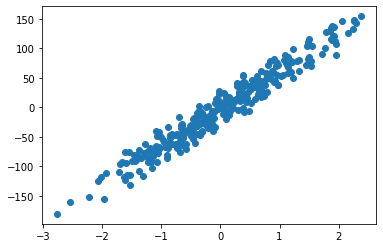

In [3]:
X, y, w_true = make_regression(n_samples=300, n_features=1, noise=15,
                               coef=True, random_state=0)
plt.scatter(X, y)
w_true

array([63.6635994])

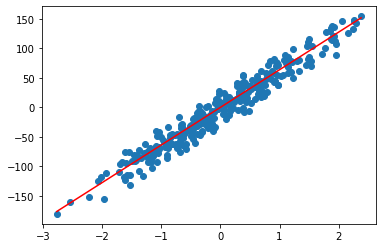

In [4]:
w = np.linalg.inv(X.T @ X) @ X.T @ (y)
plt.scatter(X, y)
x_min, x_max = X.min(), X.max()
plt.plot([x_min, x_max], [x_min * w, x_max * w], 'r')
w

In [5]:
np.mean((y - X @ w) ** 2)  # MSE

223.9801693098089

In [6]:
# use the built-in function in the numpy.linalg module
w_, sse_, _, _ = np.linalg.lstsq(X, y, rcond=None)
w_, sse_ / len(y)

(array([63.6635994]), array([223.98016931]))

### Question: How to turn a linear regression model into a classification model?

We can transform the output of a linear regression model (in the range between -inf and inf) into a value between 0 and 1 to represent **the probability that a sample belongs to a positive class**. How can we do that?

### Sigmoid Function

The sigmoid function is defined as follows:
$$ \sigma(x) = \frac{1}{1 + e^{-x}} $$

Check the range of the sigmoid function!


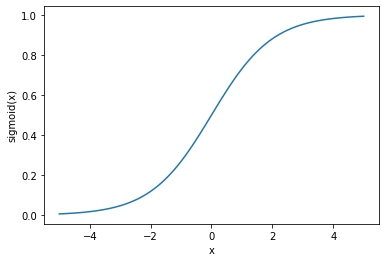

In [10]:
def sigmoid(x):
    # avoid overflow
    # if x < 0: sigma = -1 * (1 / (1 + exp(x)) - 0.5) + 0.5
    # if x > 0: sigma = 1 * (1 / (1 + exp(-x)) - 0.5) + 0.5
    # if x = 0: sigma = 0.5
    y = 1 / (1 + np.exp(-np.abs(x)))
    s = np.sign(x)
    return s * (y - 0.5) + 0.5

x = np.linspace(-5, 5, 100)
plt.plot(x, sigmoid(x))
plt.xlabel('x')
plt.ylabel('sigmoid(x)')
print('Check the range of the sigmoid function!')

## Logistic Regression

A logistic regression model is simply the combination of a linear model and a sigmoid function, or formally:
$$ f_\mathbf{w}(\mathbf{x}) = \sigma(\mathbf{w}^\top \mathbf{x}) $$
where $\sigma$ is the sigmoid function. 

### Maximum Likelihood Estimation

Now that we have a model that can output a probability $p$, how do we determine the label of a new sample? We can generate a random binary number that is 1 with probability $p$ and 0 with probability $1-p$. This is called the **Bernoulli distribution**.

Naturally we want to find the model which can maximize the chance that the prediction is correct. If a model $f_\mathbf{w}$ outputs a probability $p_i$ for a sample $\mathbf{x}_i$, and the true label is $y_i$, then the probability that the model predicts the correct label is $p_i^{y_i} (1-p_i)^{1-y_i}$. If we have $N$ samples, then the probability that the model predicts all the labels correctly is:
$$ \prod_{i=1}^N p_i^{y_i} (1-p_i)^{1-y_i} $$

We want to find the model parameters $\mathbf{w}$ that maximize this probability, formally:
$$ \begin{aligned}
\mathbf{w}^* & = \arg\max_{\mathbf{w}} \prod_{i=1}^N p_i^{y_i} (1-p_i)^{1-y_i} \\
& = \arg\max_{\mathbf{w}} \sum_{i=1}^N \left(y_i \log p_i + (1-y_i) \log (1-p_i) \right) \\
\end{aligned} $$

This is called the **maximum likelihood estimation (MLE)** method. Logarithm is applied because the product will be extremely small as $N$ increases. To turn the problem into the minimization of a loss function, we can simply define the loss as the **negative log-likelihood (NLL)**:
$$ \begin{aligned}
\mathcal{L}(\mathbf{w}) & = - \sum_{i=1}^N \left(y_i \log p_i + (1-y_i) \log (1-p_i) \right) \\
\end{aligned} $$

Now we substitute the probabilities $p_i$ with the outputs of the logistic regression model $f_\mathbf{w}$:
$$ \begin{aligned}
\mathcal{L}(\mathbf{w}) & = - \sum_{i=1}^N \left(y_i \log \sigma(\mathbf{w}^\top \mathbf{x}_i) + (1-y_i) \log (1-\sigma(\mathbf{w}^\top \mathbf{x}_i)) \right) \\
\end{aligned} $$

In [11]:
def logistic_model(w):
    """Make a logistic regression model with the given parameters."""
    w = np.asarray(w)
    return lambda x: sigmoid(x @ w)

def nll(model, X, y):
    p = model(X)
    return -np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))

features = np.hstack([np.ones((len(X), 1)), X])  # add a column of ones
labels = (y > 0).astype(int)

w = np.random.randn(features.shape[1])
clf = logistic_model(w)
clf(features)[:5], labels[:5], nll(clf, features, labels)

(array([0.59490052, 0.33208808, 0.90443806, 0.48824375, 0.24839453]),
 array([1, 0, 1, 1, 0]),
 117.61118541553229)

<ipython-input-11-41773f5b258f>:8: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))
<ipython-input-11-41773f5b258f>:8: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))


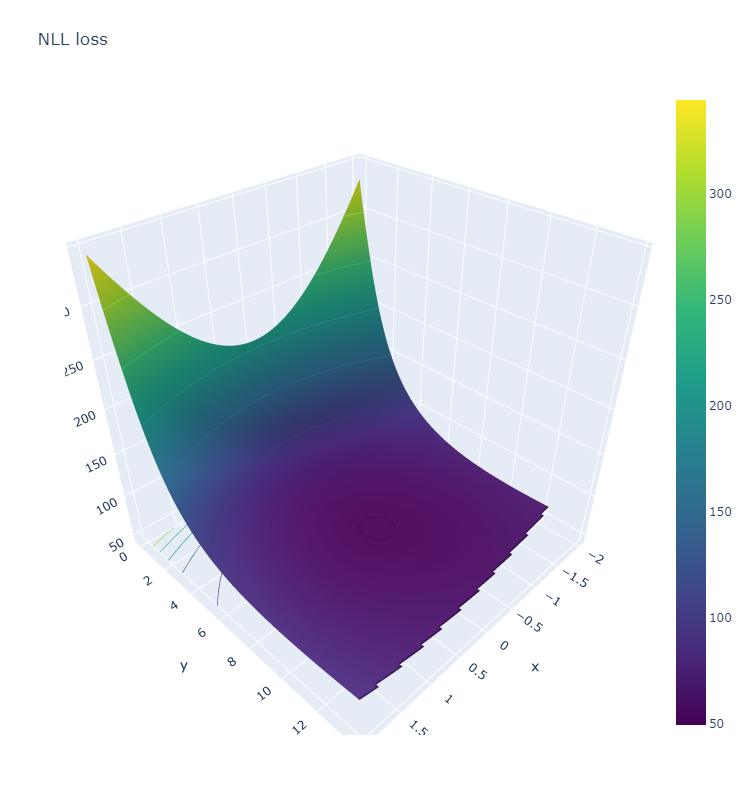

In [12]:
# create a grid of model weights/parameters
w0 = np.linspace(-2, 2, 100)
w1 = np.linspace(0, 14, 100)

# compute the loss for each model
loss = np.array([[nll(logistic_model([w0i, w1i]), features, labels)
                  for w0i in w0] for w1i in w1])

# plot the loss surface
import plotly.graph_objects as go
fig = go.Figure(data=[go.Surface(z=loss, x=w0, y=w1, colorscale='Viridis')])
fig.update_layout(title='NLL loss', autosize=False,
                  width=800, height=800, margin=dict(l=65, r=50, b=65, t=90))
fig.update_traces(contours_z=dict(show=True, usecolormap=True, size=10,
                                  highlightcolor="limegreen", project_z=True))
fig.show()

### Gradient Descent

For a convex loss function like NLL, to find the optimal parameters $\mathbf{w}^*$ that minimizes the loss, the **gradient descent** method is commonly used. The *gradient* of a scalar function $f:\mathbb{R}^n\rightarrow \mathbb{R}$ is the vector of partial derivatives of its output with respect to each of its variables:
$$ \nabla f(\mathbf{x}) = \left(\frac{\partial f}{\partial x_1}, \frac{\partial f}{\partial x_2}, \ldots, \frac{\partial f}{\partial x_n}\right)^\top $$
The gradient descent method iteratively updates the parameters $\mathbf{w}$ in the direction of the negative gradient:
$$ \mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} - \eta \nabla \mathcal{L}(\mathbf{w}^{(t)}) $$
where $\eta$ is the **learning rate**.

The gradient of the NLL loss of a logistic regression model is:
$$ \begin{aligned}
\nabla \mathcal{L}(\mathbf{w}) & = - \sum_{i=1}^N \left(y_i \nabla\log \sigma(\mathbf{w}^\top \mathbf{x}_i) + (1-y_i) \nabla\log (1-\sigma(\mathbf{w}^\top \mathbf{x}_i)) \right) \\
& = - \sum_{i=1}^N \left(y_i - \sigma(\mathbf{w}^\top \mathbf{x}_i) \right) \mathbf{x}_i \\
\end{aligned} $$
You can derive it step by step by yourself.

In [13]:
def logistic_nll_grad(model, X, y):
    p = model(X)
    return X.T @ (p - y)

def gradient_descent(make_model, X, y, grad, lr=1e-3, w_init=None,
                     n_iter=1000, tol=1e-5, random_state=None):
    trajectory = []
    if w_init is None:
        np.random.seed(random_state)
        w = np.random.randn(X.shape[1])
    else:
        w = w_init.copy()
    for i in range(n_iter):
        model = make_model(w)
        w_old = w.copy()
        g = grad(model, X, y)
        w -= lr * g
        trajectory.append(w_old)
        if np.sum((w - w_old) ** 2) < tol:
            print('Converged after {} steps'.format(i + 1))
            break
    else:
        print('Failed to converge after {} steps'.format(n_iter))
    model = make_model(w)
    model.coef = w
    model.coef_traj = np.array(trajectory)
    return model

clf = gradient_descent(logistic_model, features, labels, logistic_nll_grad,
                       lr=3e-3, tol=1e-6, random_state=0)
clf.coef

Converged after 661 steps


array([-0.24631249,  6.78246873])

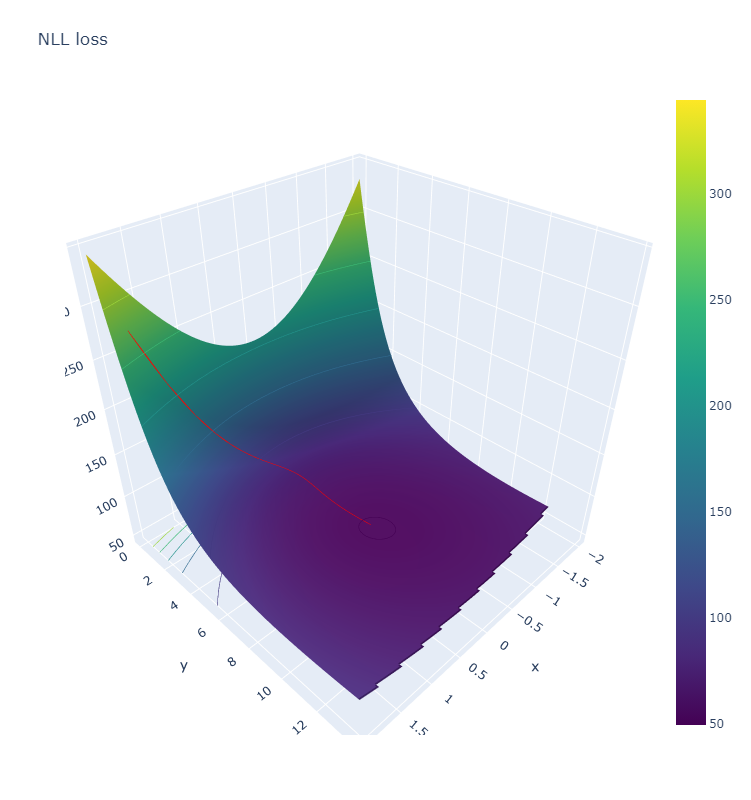

In [14]:
ws = clf.coef_traj
loss_traj = np.array([nll(logistic_model(w), features, labels) for w in ws])
traj_line = go.Scatter3d(x=ws[:, 0], y=ws[:, 1], z=loss_traj, mode='lines', 
                         marker=dict(size=2, color='red'))
fig.add_trace(traj_line)
fig

In [15]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs', max_iter=1000, tol=1e-5)
clf.fit(X, labels)
w = np.append(clf.intercept_, clf.coef_)
w

array([-0.16606127,  4.57656098])

Now let's try logistic regression on a real-world dataset.

In [17]:
from sklearn.model_selection import train_test_split

X, y = load_breast_cancer(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)
X_train.shape, X_test.shape

((426, 30), (143, 30))

Stratification is a method to ensure that the training and test sets have the same distribution of labels. For example, if we have a dataset with 90% of samples belonging to class 0 and 10% of samples belonging to class 1, we want to make sure that the training and test sets have the same distribution of labels.

In [18]:
(y.value_counts(normalize=True).values, 
 y_train.value_counts(normalize=True).values, 
 y_test.value_counts(normalize=True).values)

(array([0.62741652, 0.37258348]),
 array([0.62676056, 0.37323944]),
 array([0.62937063, 0.37062937]))

In [19]:
clf = LogisticRegression(solver='lbfgs', max_iter=3000, tol=1e-5)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000, tol=1e-05)

In [20]:
# we can investigate the learned coefficients
# positive coefficients correspond to positive associations with the positive class (malignant)
# negative coefficients correspond to negative associations with the positive class
pd.Series(clf.coef_[0], index=X.columns).sort_values()

worst concavity           -1.215580
worst compactness         -0.730885
worst concave points      -0.468266
worst texture             -0.468257
mean concavity            -0.449916
worst symmetry            -0.429722
mean perimeter            -0.319328
worst smoothness          -0.245149
mean concave points       -0.222528
mean compactness          -0.222478
worst perimeter           -0.173181
worst radius              -0.170407
mean symmetry             -0.165060
area error                -0.141319
radius error              -0.128999
mean smoothness           -0.117401
worst fractal dimension   -0.101812
concavity error           -0.087896
mean fractal dimension    -0.032609
concave points error      -0.031419
symmetry error            -0.025162
smoothness error          -0.016283
compactness error         -0.014932
worst area                -0.007228
fractal dimension error   -0.001406
mean area                  0.026999
mean texture               0.207158
texture error              0

## Classification Metrics

First, let's define some terms:
- **True Positive (TP)**: the number of samples that are correctly classified as positive.
- **True Negative (TN)**: the number of samples that are correctly classified as negative.
- **False Positive (FP)**: the number of samples that are incorrectly classified as positive.
- **False Negative (FN)**: the number of samples that are incorrectly classified as negative.

### Accuracy
$$ \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN} $$

### Precision
$$ \text{Precision} = \frac{TP}{TP + FP} $$

### Recall
$$ \text{Recall} = \frac{TP}{TP + FN} $$

### F1 Score
$$ \text{F1 Score} = 2 \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} $$

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

pred = clf.predict(X_test)
performance = dict(
    accuracy=accuracy_score(y_test, pred),
    precision=precision_score(y_test, pred),
    recall=recall_score(y_test, pred),
    F1=f1_score(y_test, pred),
)
performance

{'accuracy': 0.9370629370629371,
 'precision': 0.9550561797752809,
 'recall': 0.9444444444444444,
 'F1': 0.9497206703910613}

### ROC Curve and AUC

The **receiver operating characteristic (ROC)** curve is a plot of the **true positive rate (TPR)** against the **false positive rate (FPR)**. 

The TPR is defined as $\frac{TP}{TP + FN}$, and the FPR is defined as $\frac{FP}{FP + TN}$.

In [22]:
# the predict_proba method returns the probabilities for each class
p_test = clf.predict_proba(X_test)
p_test.shape

(143, 2)

In [24]:
p_test[:5]

array([[1.32759851e-02, 9.86724015e-01],
       [9.99982860e-01, 1.71395910e-05],
       [9.99994262e-01, 5.73826002e-06],
       [3.88966653e-04, 9.99611033e-01],
       [9.99539468e-01, 4.60532133e-04]])

In [25]:
np.all(p_test.sum(axis=1) == 1)

True

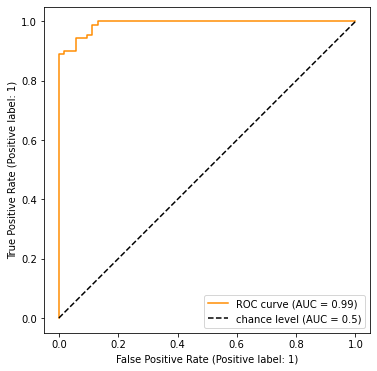

In [26]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay

fig, ax = plt.subplots(figsize=(6, 6))

RocCurveDisplay.from_predictions(
    y_true=y_test,
    y_pred=p_test[:, 1],
    name=f"ROC curve",
    color="darkorange",
    ax=ax,
)

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.legend(loc="lower right")
plt.show()

In [113]:
roc_auc_score(y_test, p_test[:, 1])

0.9909853249475892

## Multiclass Classification

The probability produced by a logistic regression can only be used to determine a binary label. But for any binary classifier, we can extend it to a $K$-class classifier by 

1. The one-vs-rest strategy, also known as one-vs-all, consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes. In addition to its computational efficiency (only n_classes classifiers are needed), one advantage of this approach is its interpretability. Since each class is represented by one and only one classifier, it is possible to gain knowledge about the class by inspecting its corresponding classifier. This is the most commonly used strategy and is the default choice by sklearn.

2. The one-vs-one strategy constructs one classifier per pair of classes. At prediction time, the class which received the most votes is selected. Since it requires to fit n_classes * (n_classes - 1) / 2 classifiers, this method is usually slower than one-vs-the-rest, due to its O(n_classes^2) complexity. However, this method may be advantageous for algorithms such as kernel algorithms which don’t scale well with n_samples. This is because each individual learning problem only involves a small subset of the data whereas, with one-vs-the-rest, the complete dataset is used n_classes times. To use OvO in sklearn, we can set `multi_class='ovo'` when creating the classifier.

In [33]:
from sklearn.datasets import load_digits

X, y = load_digits(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

clf = LogisticRegression(solver='lbfgs', max_iter=3000, tol=1e-5)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000, tol=1e-05)

### Confusion Matrix

The confusion_matrix function evaluates classification accuracy by computing the confusion matrix with each row corresponding to the true class.

By definition, entry $i,j$ in a confusion matrix is the number of observations actually in class $i$, but predicted to be in class $j$.

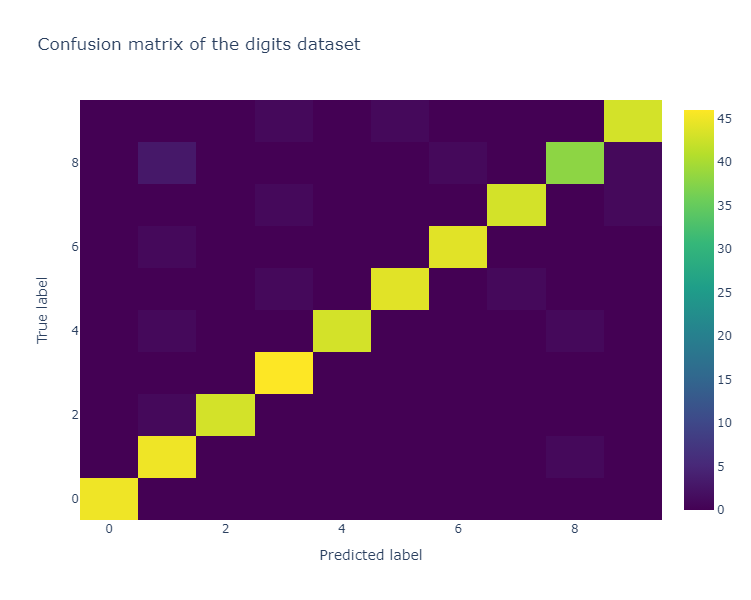

In [115]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, clf.predict(X_test))
fig = go.Figure(data=go.Heatmap(z=cm, x=clf.classes_, y=clf.classes_, colorscale='Viridis'))
fig.update_layout(title='Confusion matrix of the digits dataset',
                  autosize=False, width=600, height=600)
fig.update_xaxes(title_text='Predicted label')
fig.update_yaxes(title_text='True label')
fig

### Micro and Macro Averaging

In order to evaluate the performance of a multiclass classifier, we calculate TP, TN, FP, FN for each binary sub-classifier (OvR or OvO) in the multiclass classifier. Then we can average the results in different ways:

- **Micro averaging**: calculate the total TP, TN, FP, and FN, and then compute the metrics based on these numbers.
- **Macro averaging**: compute the metrics first and then average them.

In [28]:
# We implement an OvR logistic regression classifier from scratch

classes = np.sort(np.unique(y_train))
multiclass_clf = []

for c in classes:
    N_c = np.sum(y_train == c)
    print(f"Class {c}: {N_c} samples")
    y_c = (y_train == c).astype(int)
    clf = gradient_descent(logistic_model, X_train, y_c, logistic_nll_grad,
                           n_iter=1000, lr=2e-3, random_state=0)
    multiclass_clf.append(clf)

def predict(mcls_clf, X):
    return np.array([clf(X) for clf in mcls_clf]).argmax(axis=0)

def evaluate(models, X, y):
    results = []
    for c, model in enumerate(models):
        prob = model(X)
        pred = prob > 0.5
        true = y == c
        TP = np.sum(pred & true)
        FP = np.sum(pred & ~true)
        FN = np.sum(~pred & true)
        TN = np.sum(~pred & ~true)
        accuracy = (TP + TN) / (TP + FP + FN + TN)
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1 = 2 * precision * recall / (precision + recall)
        roc_auc = roc_auc_score(true, prob)
        results.append(dict(
            TP = TP, FP = FP, FN = FN, TN = TN,
            accuracy = accuracy, precision = precision, recall = recall, 
            f1 = f1, roc_auc = roc_auc
        ))
    return pd.DataFrame(results)
    
report = evaluate(multiclass_clf, X_test, y_test)
report

Class 0: 133 samples
Converged after 216 steps
Class 1: 136 samples
Failed to converge after 1000 steps
Class 2: 133 samples
Converged after 91 steps
Class 3: 137 samples
Failed to converge after 1000 steps
Class 4: 136 samples
Converged after 466 steps
Class 5: 136 samples
Converged after 370 steps
Class 6: 136 samples
Converged after 468 steps
Class 7: 134 samples
Converged after 539 steps
Class 8: 131 samples
Failed to converge after 1000 steps
Class 9: 135 samples
Failed to converge after 1000 steps


,TP,FP,FN,TN,accuracy,precision,recall,f1,roc_auc
0,44,0,1,405,0.997778,1.000000,0.977778,0.988764,0.999945
1,45,20,1,384,0.953333,0.692308,0.978261,0.810811,0.980306
2,43,1,1,405,0.995556,0.977273,0.977273,0.977273,0.988524
3,45,14,1,390,0.966667,0.762712,0.978261,0.857143,0.987893
4,43,2,2,403,0.991111,0.955556,0.955556,0.955556,0.987462
5,44,1,2,403,0.993333,0.977778,0.956522,0.967033,0.998628
6,43,2,2,403,0.991111,0.955556,0.955556,0.955556,0.987462
7,45,4,0,401,0.991111,0.918367,1.000000,0.957447,0.999945
8,31,12,12,395,0.946667,0.720930,0.720930,0.720930,0.846866
9,42,10,3,395,0.971111,0.807692,0.933333,0.865979,0.967078


In [30]:
weights = report['TP'] + report['FN']
weights /= weights.sum()
weights

0    0.100000
1    0.102222
2    0.097778
3    0.102222
4    0.100000
5    0.102222
6    0.100000
7    0.100000
8    0.095556
9    0.100000
dtype: float64

In [31]:
TP, FP, FN, TN = report[['TP', 'FP', 'FN', 'TN']].sum()
micro_metrics = pd.Series(dict(
    accuracy = (TP + TN) / (TP + FP + FN + TN),
    precision = TP / (TP + FP),
    recall = TP / (TP + FN),
    f1 = 2 * TP / (2 * TP + FP + FN),
))
macro_metrics = report[['accuracy', 'precision', 'recall', 'f1']].mean()
weighted_metrics = (report[['accuracy', 'precision', 'recall', 'f1']] *
                    weights.values[:, None]).sum()
pd.concat([micro_metrics, macro_metrics, weighted_metrics], 
          axis=1, keys=['micro', 'macro', 'weighted'])

,micro,macro,weighted
accuracy,0.979778,0.979778,0.979832
precision,0.865580,0.876817,0.876847
recall,0.944444,0.943347,0.944444
f1,0.903294,0.905649,0.906129


In [36]:
p_train = predict(multiclass_clf, X_train)
accuracy_score(y_train, p_train)

0.9732739420935412

### Classification Report

In [34]:
from sklearn.metrics import classification_report

p_test = clf.predict(X_test)
report = classification_report(y_test, p_test, output_dict=True)
report = pd.DataFrame(report).T
report

,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,45.000000
1,0.882353,0.978261,0.927835,46.000000
2,1.000000,0.977273,0.988506,44.000000
3,0.938776,1.000000,0.968421,46.000000
4,1.000000,0.955556,0.977273,45.000000
5,0.977778,0.956522,0.967033,46.000000
6,0.977778,0.977778,0.977778,45.000000
7,0.977273,0.955556,0.966292,45.000000
8,0.950000,0.883721,0.915663,43.000000
9,0.955556,0.955556,0.955556,45.000000


In [37]:
accuracy_score(clf.predict(X_train), y_train)

1.0

### Multiclass ROC Curves

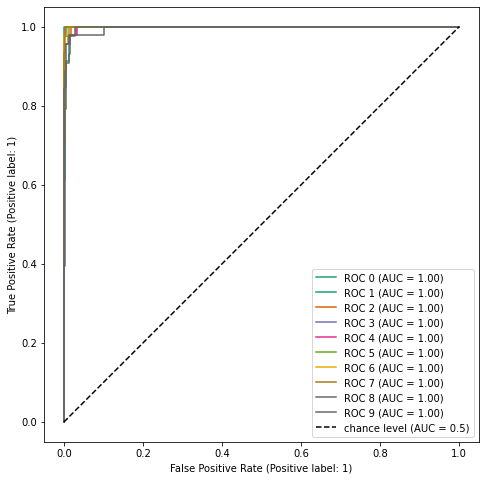

In [153]:
fig, ax = plt.subplots(figsize=(8, 8))
p_test_proba = clf.predict_proba(X_test)
colors = plt.cm.Dark2(np.linspace(0, 1, len(classes)))

for i in classes:
    RocCurveDisplay.from_predictions(
        y_true=(y_test == i).astype(int),
        y_pred=p_test_proba[:, i],
        name=f"ROC {i}",
        color=colors[i],
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.legend(loc="lower right")
plt.show()

## Exercises

1. Write functions that find the number of true positives, true negatives, false positives, and false negative given the true labels and the predicted labels.

2. Complete the ROC curve function.

In [ ]:
def roc_curve(model, X, y):
    """Compute the ROC curve for a binary classifier."""
    y_pred = model.predict_proba(X)[:, 1]
    thresholds = np.sort(y_pred)
    tpr = []
    fpr = []
    for threshold in thresholds:
        y_pred_binary = (y_pred >= threshold).astype(int)
        ...  # TODO: compute true positive rate and false positive rate
        tpr.append(...)
        fpr.append(...)
    return np.array(fpr), np.array(tpr)

X, y = load_breast_cancer(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

clf = LogisticRegression(max_iter=3000).fit(X_train, y_train)
fpr, tpr = roc_curve(clf, X_test, y_test)

plt.plot(fpr, tpr)
plt.axis("square")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.show()

3. Write a function that computes the confusion matrix, given the true labels and the predicted labels. Normalize the confusion matrix so that each element at $(i,j)$ represents the probability of the predicted label $j$ given the true label $i$. In other words, each row should sum to 1.

4. What does it mean when the precision is higher than the recall? In the case of a breast cancer diagnosis, is it better than having a higher recall than precision? Which one is more important?

5. Think about how to calculate the micro-average ROC-AUC score. Check the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) to see if your idea is the same as implemented in sklearn.